In [89]:
'''
FUNCTIONS
Many functions for fit to basic lorentzians and also for the MB parameters:
    E - our x values, usually v [mm/s]
    I - intensity (usually of lowest peak pair)
    B_hf - hyperfine splitting magnetic field
    IS - isomer shift
    gamma - width of peak
    QS - quadrapole splitting (for some functions)
    b - baseline, number of counts without absorbtion

DATA
Mica fits and final table for comparing relative peaks.
'''

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import spinmob as s

In [90]:
'''
giving a fitter, returns an array of the fitted lorentzian2USDoublet parameters and errors in 2D array
arg: my_fitter = fit
'''
def getFits_lor(my_fitter):
    
    di = my_fitter.get_fit_results()

    listF = [[di['IS'], di['IS.std']], [di['QS'], di['QS.std']], [di['gamma'], di['gamma.std']] ]
    listT = [[di['I_L'],  di['I_L.std']], [di['I_R'], di['I_R.std']],  [di['IS_2'], di['IS_2.std']]]
    listB = [[di['IS_2'],  di['IS_2.std']], [di['QS_2'], di['QS_2.std']],  [di['b'], di['b.std']], [di['c'], di['c.std']]]

    return listF + listT + listB

"""
Takes array of channels, and m, b of linear function
Returns array of velocities [mmsec]
"""
def chan_to_velo(channels, m, b):
    v = [m[0]*c + b[0] for c in channels]
    return v

def average(a, b, offset):
    
    center = (a[0] - b[0]) / 2.0 + offset[0]
    err = np.sqrt((np.sqrt((a[1])**2 + (b[1])**2)*0.5)**2+(offset[1])**2)
    
    return [center, err]

def lorentzian6const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, center_3, dist_3, gamma_3, A_3, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_3 = (E-(center_3 - dist_3))**2 + (gamma_3/2)**2
    denom_4 = (E-(center_3 + dist_3))**2 + (gamma_3/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_3*gamma_3**2/denom_4 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b


def lorentzian6Magt(E, I, B_hf, IS, gamma, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS ))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b
    
def lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS -QS))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b

#2 magnetic sites (so twice 6 peaks) with one baseline
def multiSiteLor6(E, I, B_hf, IS, gamma, QS, I_2, B_hf_2, IS_2, gamma_2, QS_2, b):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b)
    Bsites = lorentzian6MagtQS(E, I_2, B_hf_2, IS_2, gamma_2, QS_2, 0)
    
    return Asites + Bsites

#one magnetic site and one electric site with one baseline
def multiSiteMag_Ele(E, I, B_hf, IS, gamma, QS, I_2, center, dist, gamma_2, b):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b)
    Bsites = lorentzian2Const(E, center, dist, gamma_2, I_2, 0)
    
    return Asites + Bsites

#2 lorentzians added together with one offset
def lorentzian2Const(E, center, dist, gamma, I, b):
    denom = (E- (center - dist) )**2 + (gamma/2)**2
    denom_2 = (E- (center + dist) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#2 lorentzians added together with one offset
def lorentzian2QS(E, IS, QS, gamma, I, b):

    denom = (E- (IS - QS) )**2 + (gamma/2)**2
    denom_2 = (E- (IS + QS) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#3 lorentzians doublets added together with quadratic offset
def lorentzian3Doublet(E, IS, QS, gamma, I, IS_2, QS_2, I_2, IS_3, QS_3, I_3, b, c):

    Asite = lorentzian2QS(E, IS, QS, gamma, I, 0)
    Bsite = lorentzian2QS(E, IS_2, QS_2, gamma, I_2, 0)
    Csite = lorentzian2QS(E, IS_3, QS_3, gamma, I_3, 0)

    return Asite + Bsite + Csite + b+ c*E**2

#2 lorentzians doublets added together with quadratic offset
def lorentzian2USDoublet(E, IS, QS, gamma, I_L, I_R, IS_2, QS_2, I_2, b, c):

    Asite = lorentzian2USQS(E, IS, QS, gamma, I_L, I_R, 0)
    Bsite = lorentzian2QS(E, IS_2, QS_2, gamma, I_2, 0)

    return Asite + Bsite + b + c*E**2

#2 lorentzians added together with one offset
def lorentzian2USQS(E, IS, QS, gamma, I_L, I_R, b):

    denom = (E- (IS - QS) )**2 + (gamma/2)**2
    denom_2 = (E- (IS + QS) )**2 + (gamma/2)**2

    return I_L*gamma**2/denom + I_R*gamma**2/denom_2 + b


In [91]:
# channel to velocity relation from calibration data
b = [11.000776381475806, 0.0011164921537570854] 
m = [-0.08527733629051013, 8.194955387410484e-06]

fits=[]

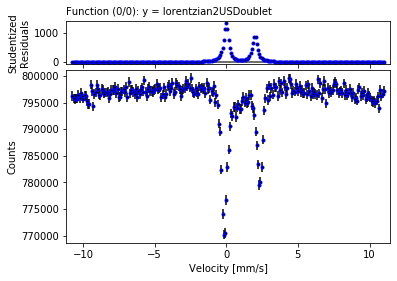

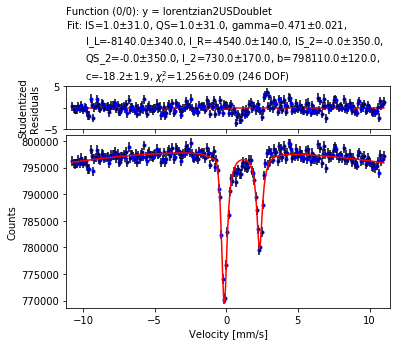

In [92]:
#"powder"

data = np.loadtxt(".//data//Mica_Jan29_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

# guess= 'IS=1.0, QS=0.05, gamma=0.4, I=-3e4, QS_2=1.0, IS_2=0.2, I_2=-5e3, IS_3=0.2, QS_3=0.2, I_3=-5e3, b=8e5, c=-1e-3'
# my_fitter.set_functions(f=lorentzian3Doublet, p=guess)

guess= 'IS=1.0, QS=1.0, gamma=0.4, I_L=-3e5, I_R=-2e5, IS_2=0.5, QS_2=.05, I_2=5e3, b=8e5, c=-1e-3'
my_fitter.set_functions(f=lorentzian2USDoublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
fit = my_fitter.get_fit_results()
# resultsLS = getFits_lor(my_fitter, 0)

fitP = getFits_lor(my_fitter)
fits.append(fitP)

## Sheet Samples

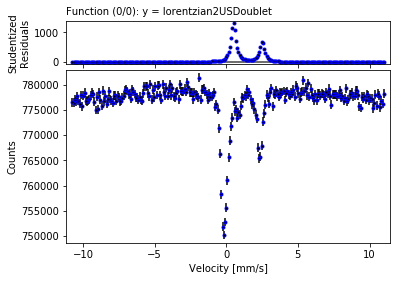

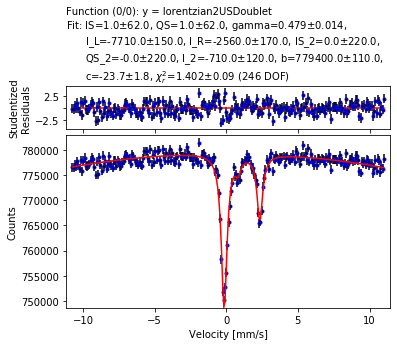

In [93]:
# degrees from vertical: 0

data = np.loadtxt(".//data//MicaSheet_0_Jan30_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess= 'IS=1.5, QS=1.0, gamma=0.4, I_L=-3e5, I_R=-1.5e5, IS_2=0.5, QS_2=.05, I_2=5e3, b=7.8e5, c=-1e-3'
my_fitter.set_functions(f=lorentzian2USDoublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# fit = my_fitter.get_fit_results()
# resultsLS = getFits_lor(my_fitter, 0)
fit0 = getFits_lor(my_fitter)
fits.append(fit0)

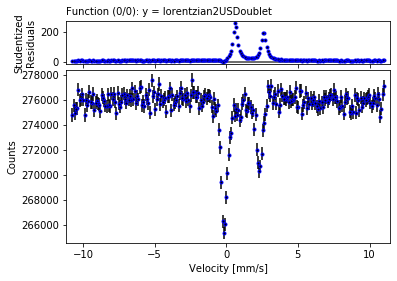

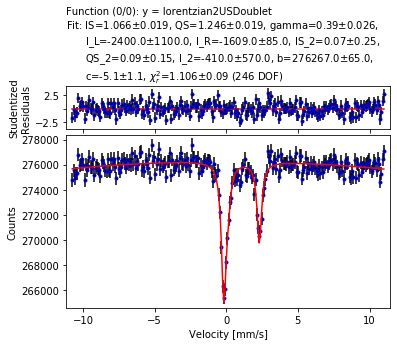

In [94]:
# degrees from vertical: 25

data = np.loadtxt(".//data//MicaSheet_25_Jan30_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess= 'IS=1.6, QS=1.0, gamma=0.4, I_L=-4e4, I_R=-2.5e4, IS_2=0.5, QS_2=.05, I_2=5e3, b=2.7e5, c=-1e-3'
my_fitter.set_functions(f=lorentzian2USDoublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
fit = my_fitter.get_fit_results()
# resultsLS = getFits_lor(my_fitter, 0)
fit25 = getFits_lor(my_fitter)
fits.append(fit25)

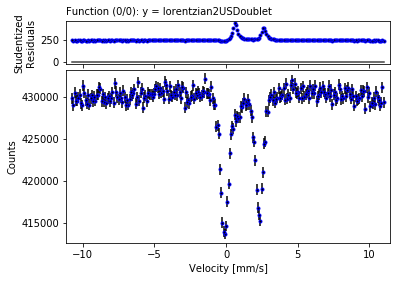

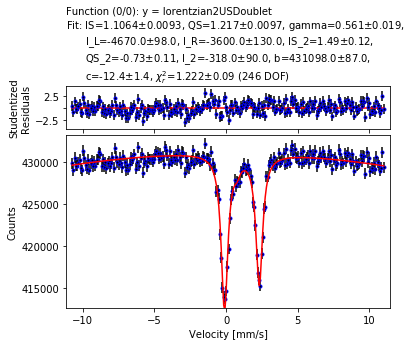

In [95]:
# degrees from vertical: 50

data = np.loadtxt(".//data//MicaSheet_50_Jan31_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess= 'IS=1.6, QS=1.0, gamma=0.4, I_L=-4e4, I_R=-2.5e4, IS_2=0.5, QS_2=.05, I_2=5e3, b=2.7e5, c=-1e-3'
my_fitter.set_functions(f=lorentzian2USDoublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# fit = my_fitter.get_fit_results()
# resultsLS = getFits_lor(my_fitter, 0)
fit50 = getFits_lor(my_fitter)
fits.append(fit50)


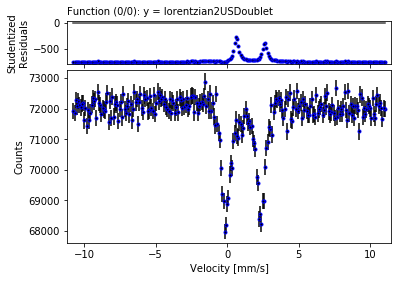

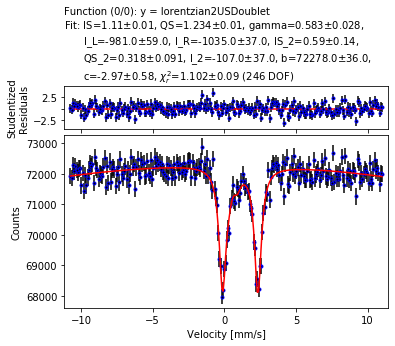


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 538401.281 +/- 0.09, 246.0 DOF)
  IS         = 1.6
  QS         = 1.0
  gamma      = 0.4
  I_L        = -40000.0
  I_R        = -25000.0
  IS_2       = 0.5
  QS_2   

In [102]:
# degrees from vertical: 70

data = np.loadtxt(".//data//MicaSheet_70_Jan30_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess= 'IS=1.6, QS=1.0, gamma=0.4, I_L=-4e4, I_R=-2.5e4, IS_2=0.5, QS_2=.05, I_2=5e3, b=2.7e5, c=-1e-3'
my_fitter.set_functions(f=lorentzian2USDoublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# fit = my_fitter.get_fit_results()
# resultsLS = getFits_lor(my_fitter, 0)
# fit70 = getFits_lor(my_fitter)
# fits.append(fit70)

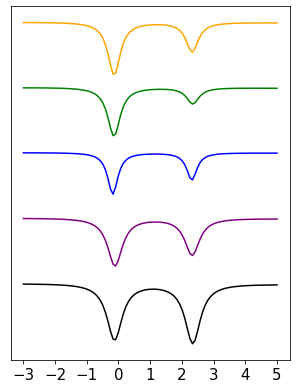

In [136]:
v = np.linspace(-3, 5, 100)
col = ['orange', 'g', 'b', 'purple', 'black']
i = 0

base = 10000 

plt.figure(figsize=(5, 6.5))
plt.xticks(fontsize=15)
plt.yticks([])

for fit in fits:
    
    I_L = fit[3][0]*base/fit[8][0]
    I_R = fit[4][0]*base/fit[8][0]
    I_2 = fit[7][0]*base/fit[8][0]
    c = fit[9][0]*base/fit[8][0]
    
    plt.plot(v, lorentzian2USDoublet(v, fit[0][0], fit[1][0], fit[2][0], I_L, I_R, fit[5][0], fit[6][0], I_2, base, c), color=col[i])
    i+=1
    base -= 500

plt.show()